In [23]:
from mne_bids import (BIDSPath,read_raw_bids)
import mne_bids
import mne
import importlib
import ccs_eeg_utils
from IPython.display import clear_output
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [24]:
def plot_data(data, sampling_rate=500, start=0, end=7):
    # Calculate start and end indices
    start_idx = int(start * sampling_rate)
    end_idx = int(end * sampling_rate) + 1

    # Generate time axis
    time_axis = np.arange(start_idx, end_idx) / sampling_rate

    # Plot the data
    plt.plot(time_axis, data[0][0].T[start_idx:end_idx])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"EEG Signal from {start} to {end} seconds")
    plt.show()

In [25]:
bids_root = "./data/"
subject_id = '001'


bids_path = BIDSPath(subject=subject_id, run="02", task="ContinuousVideoGamePlay",
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

# read the file
raw = read_raw_bids(bids_path)
# fix the annotations readin
ccs_eeg_utils.read_annotations_core(bids_path,raw)
clear_output()

In [26]:
raw.load_data()
raw_unmodified = raw.copy()

Reading 0 ... 1398674  =      0.000 ...  2797.348 secs...


In [27]:
raw = raw_unmodified.copy()

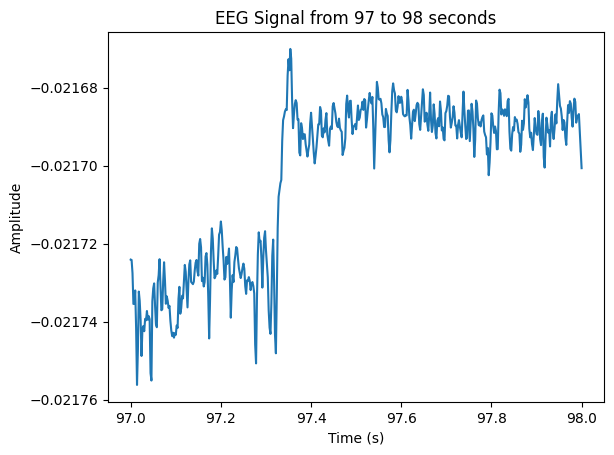

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.10 Hz)
- Filter length: 165001 samples (330.002 s)



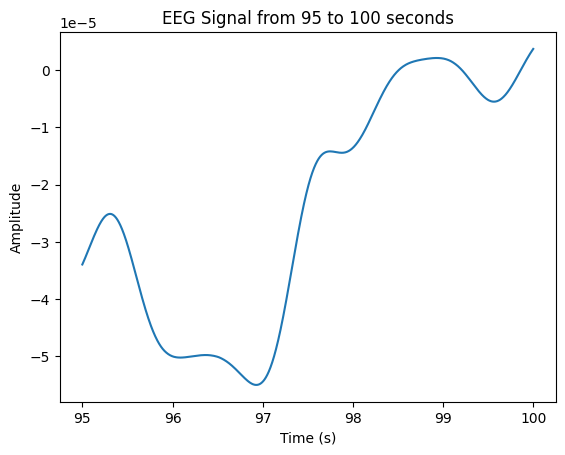

<RawEEGLAB | sub-001_task-ContinuousVideoGamePlay_run-02_eeg.fdt, 65 x 1398675 (2797.3 s), ~1.35 GiB, data loaded>

In [28]:
#Pipeline as suggested by paper
raw = raw_unmodified.copy()
plot_data(raw, start=97, end=98)
raw.filter(0.01, 0.1, picks="all")
plot_data(raw, start=95, end=100)
# raw.resample(1)
# plot_data(raw, 1)
raw.apply_hilbert(picks="all")
#plot_data(raw, start=95, end=100)

## Compute bin standard deviation
- For each event calculate difference to standard deviation

In [29]:
def create_bins(data, num_bins=8):
    bin_size = 2 * np.pi / num_bins
    bins = [[] for i in range(num_bins)]
    for element in data:
        bin_index = int((element + np.pi) // bin_size)
        bins[bin_index].append(element)
    return bins

def get_bin_probabilities(bins):
    sum = 0
    for bin in bins:
        sum += len(bin)
    return [len(bin)/sum for bin in bins]

def get_bin_deviation(data, timestamps, baseline_method, timespan = 1 * 500, num_bins = 8):
    if baseline_method == "exclude_event":
        base_data = list(data[0:int(timestamps[0]-timespan/2)])
        for i in range(len(timestamps)-1):
            base_data.extend(data[int((timestamps[i]+timespan/2)):int((timestamps[i+1]-timespan/2))])
        base_data.extend(data[int((timestamps[len(timestamps)-1]+timespan/2)):len(data)])
    if baseline_method == "include_event":
        base_data = data
    if baseline_method == "naive":
        default = [0.125]*8
    else:
        bins = create_bins(base_data, num_bins)
        default = get_bin_probabilities(bins)

    combined_data = []
    for timestamp in timestamps:
        combined_data.extend(data[int((timestamp-timespan/2)):int((timestamp+timespan/2))])

    event_bins = create_bins(combined_data, num_bins)
    event_probability = get_bin_probabilities(event_bins)

    deviation = []
    for i in range(len(default)):
        deviation.append(100*(event_probability[i]/default[i] - 1))

    return deviation

def get_total_deviation(data, timestamps, baseline_method, timespan = 1, sampling_rate = 500, num_bins = 8):
    print(len(timestamps))
    total_deviation = [0 for i in range(num_bins)]
    for i in range(len(data)):
        deviation = get_bin_deviation(data[i], [timestamp*sampling_rate for timestamp in timestamps], baseline_method, timespan*sampling_rate, num_bins)
        for i in range(len(deviation)):
            total_deviation[i] += deviation[i]
    
    for i in range(len(total_deviation)):
        total_deviation[i] /= len(data)
    return total_deviation


In [30]:
test = np.angle(raw.get_data(picks="all"))
data = test[10:11]

1


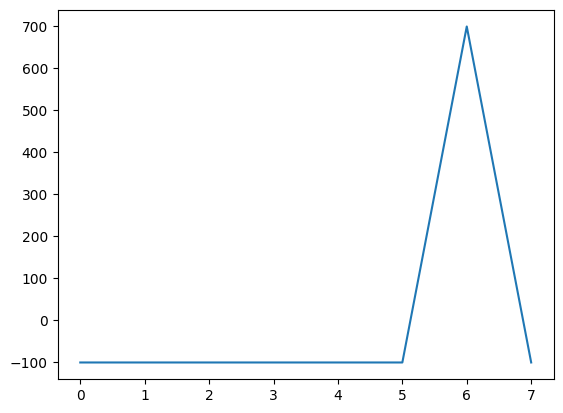

In [31]:
total_deviation = get_total_deviation(data, [115.014], "naive", sampling_rate=500)
plt.plot([i for i in range(8)], total_deviation)
plt.show()

## All subjects:

In [32]:
def get_deviation_for_subjects(subjects, behavior, channels, num_bins=8, sampling_rate=500, window=1, baseline_method="exclude_event"):
    deviation = [0]*num_bins   
    count = 0
    deviations = []

    for sub in range(1, 1+subjects):
        print(f"Subject {sub}...")
        bids_root = "./data/"
        subject_id = str(sub).zfill(3)

        bids_path = BIDSPath(subject=subject_id, run="02", task="ContinuousVideoGamePlay",
                            datatype='eeg', suffix='eeg',
                            root=bids_root)

        # read the file
        raw = read_raw_bids(bids_path)
        # fix the annotations readin
        ccs_eeg_utils.read_annotations_core(bids_path,raw)
        clear_output()
        raw.load_data()
        raw.filter(0.01, 0.1, picks="all", verbose=False)
        raw.apply_hilbert(picks="all")
        test = np.angle(raw.get_data(picks="all"))

        df = pd.read_csv(f'data/sub-{subject_id}/eeg/sub-{subject_id}_task-ContinuousVideoGamePlay_run-02_events.tsv', sep='\t')
        filtered_df = df[df['trial_type'] == behavior]

        # for i in range(0, 65):
        res = np.angle(raw.get_data(picks="all"))
        data = res[channels]
        curr_deviation = get_total_deviation(data, [entry for entry in filtered_df["onset"]], baseline_method, sampling_rate=sampling_rate, timespan=window, num_bins=num_bins, )
        deviations.append(curr_deviation)
        weight = len(filtered_df)
        for i in range(len(deviation)):
            deviation[i] += curr_deviation[i]*weight
        count += weight

    return [dev/count for dev in deviation], deviations


In [33]:
behaviors = ["STATUS", "GAME OVER", "SHOOT_BUTTON", "MISSILE_HIT_ENEMY", "COLLECT_STAR", "PLAYER_CRASH_ENEMY", "PLAYER_CRASH_WALL", "COLLECT_AMMO"]
deviation = []

In [34]:
def plot_seperated(aggregated, not_aggregated):
    color_map = cm.get_cmap('tab10', len(not_aggregated))  # You can change 'tab10' to other colormaps

    for i, deviation in enumerate(not_aggregated):
        plt.plot([j for j in range(8)], deviation, color=color_map(i))

    plt.plot([j for j in range(8)], aggregated, color="black", linewidth=3, linestyle='dashed')

    plt.show()

In [39]:
def plot_123(*aggregated, labels=None):
    color_map = cm.get_cmap('tab10', len(aggregated))
    if labels is None:
        labels = [f"Series {i+1}" for i in range(len(aggregated))]  # Default labels
    for i in range(len(aggregated)):
        plt.plot(
            [j for j in range(8)], 
            aggregated[i], 
            color=color_map(i), 
            label=labels[i]
        )
    plt.legend()
    plt.show()

/var/folders/zj/7fxv5dh53xs9bw4_55222q6c0000gn/T/ipykernel_91509/1612689852.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(aggregated))


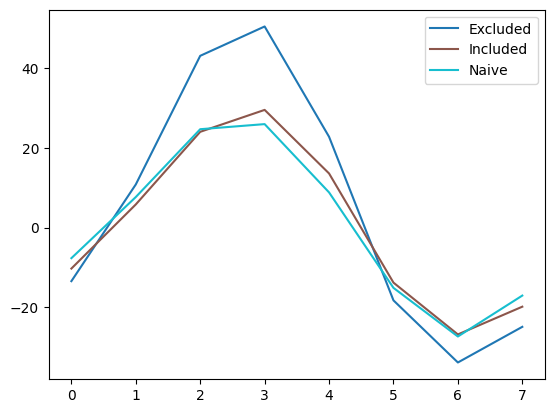

In [40]:
aggregated_excluded, _ = get_deviation_for_subjects(17, "SHOOT_BUTTON", range(3, 4))
aggregated_included, _ = get_deviation_for_subjects(17, "SHOOT_BUTTON", range(3, 4), baseline_method="include_event")
aggregated_base, _ = get_deviation_for_subjects(17, "SHOOT_BUTTON", range(3, 4), baseline_method="naive")

plot_123(aggregated_excluded, aggregated_included, aggregated_base, labels=["Excluded", "Included", "Naive"])

In [17]:
aggregated, not_aggregated = get_deviation_for_subjects(17, "SHOOT_BUTTON", range(3, 4))
plot_seperated(aggregated, not_aggregated)
plot_123(aggregated)

Reading 0 ... 1004199  =      0.000 ...  2008.398 secs...


KeyboardInterrupt: 

Reading 0 ... 954499  =      0.000 ...  1908.998 secs...
247


/var/folders/zj/7fxv5dh53xs9bw4_55222q6c0000gn/T/ipykernel_43206/9202195.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(not_aggregated))  # You can change 'tab10' to other colormaps


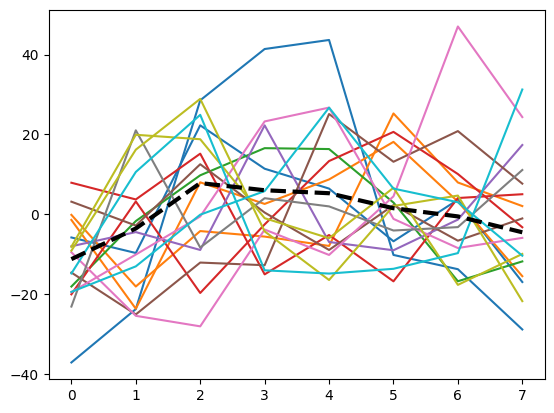

In [64]:
aggregaed, not_aggregated = get_deviation_for_subjects(17, "MISSILE_HIT_ENEMY", range(8,9))
plot_seperated(aggregaed, not_aggregated)

In [59]:
aggregaed

[-0.6638118885083526,
 -0.21145878203521296,
 0.4578286117069132,
 0.3522204805694689,
 0.3082951208352838,
 0.08705283751026556,
 -0.033696899807175475,
 -0.2677104551531954]

Reading 0 ... 954499  =      0.000 ...  1908.998 secs...
652


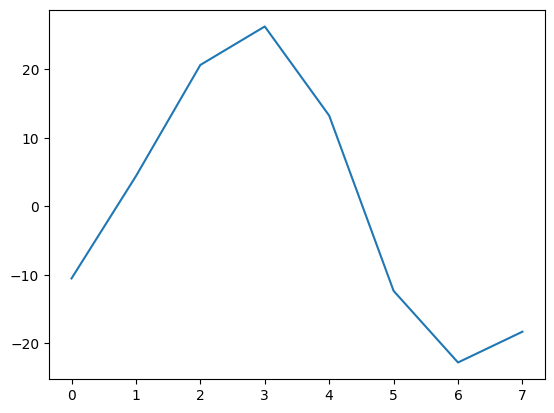

In [32]:
deviation.append(get_deviation_for_subjects(17, "SHOOT_BUTTON", range(3,4)))

plt.plot([i for i in range(8)], deviation[len(deviation)-1])
#plt.yticks([-1+i/10 for i in range(21)])
plt.show()

Reading 0 ... 954499  =      0.000 ...  1908.998 secs...
753


/var/folders/zj/7fxv5dh53xs9bw4_55222q6c0000gn/T/ipykernel_43206/9202195.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(not_aggregated))  # You can change 'tab10' to other colormaps


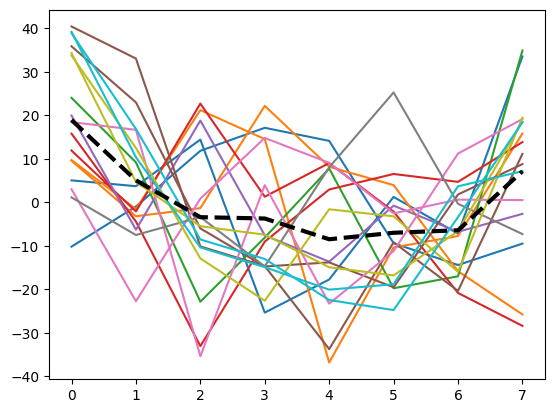

In [76]:
aggregated, not_aggregated = get_deviation_for_subjects(17, "COLLECT_STAR", range(48,49))
plot_seperated(aggregated, not_aggregated)

In [ ]:
plot_123(aggregated)

Reading 0 ... 954499  =      0.000 ...  1908.998 secs...
753


/var/folders/zj/7fxv5dh53xs9bw4_55222q6c0000gn/T/ipykernel_43206/9202195.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(not_aggregated))  # You can change 'tab10' to other colormaps


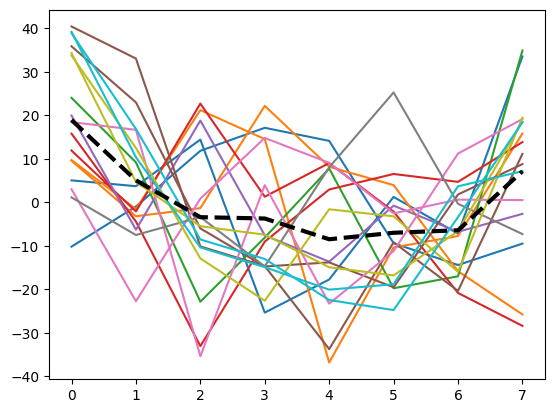

In [67]:
aggregated, not_aggregated = get_deviation_for_subjects(17, "COLLECT_STAR", range(48,49))
plot_seperated(aggregated, not_aggregated) 

Reading 0 ... 954499  =      0.000 ...  1908.998 secs...
54


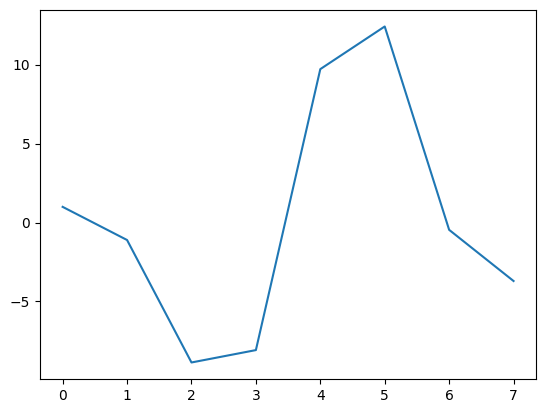

In [35]:
deviation.append(get_deviation_for_subjects(17, "COLLECT_AMMO", range(49,50)))

plt.plot([i for i in range(8)], deviation[len(deviation)-1])
#plt.yticks([-1+i/10 for i in range(21)])
plt.show()

Reading 0 ... 954499  =      0.000 ...  1908.998 secs...
211


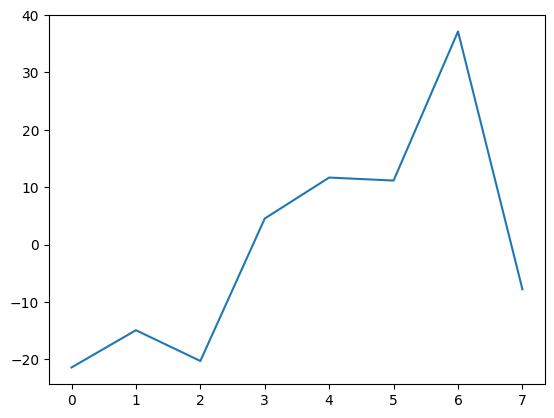

In [36]:
deviation.append(get_deviation_for_subjects(17, "PLAYER_CRASH_WALL", range(10,11)))

plt.plot([i for i in range(8)], deviation[len(deviation)-1])
#plt.yticks([-1+i/10 for i in range(21)])
plt.show()

Reading 0 ... 1398674  =      0.000 ...  2797.348 secs...
247


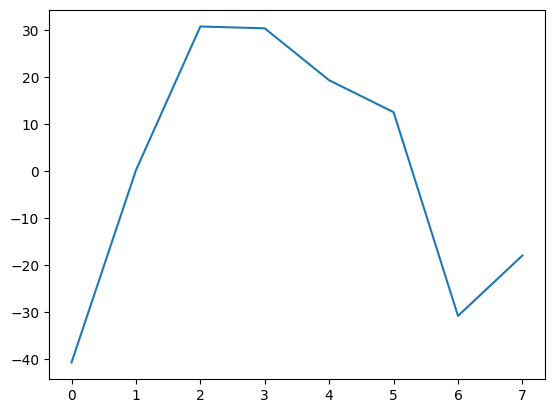

In [37]:
deviation.append(get_deviation_for_subjects(1, "PLAYER_CRASH_WALL", range(10,11)))

plt.plot([i for i in range(8)], deviation[len(deviation)-1])
#plt.yticks([-1+i/10 for i in range(21)])
plt.show()

Reading 0 ... 954499  =      0.000 ...  1908.998 secs...
211


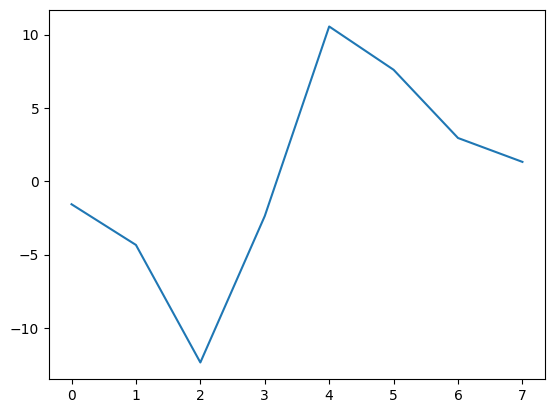

In [38]:
deviation.append(get_deviation_for_subjects(17, "PLAYER_CRASH_WALL", range(0,65)))

plt.plot([i for i in range(8)], deviation[len(deviation)-1])
plt.show()

Reading 0 ... 954499  =      0.000 ...  1908.998 secs...
211


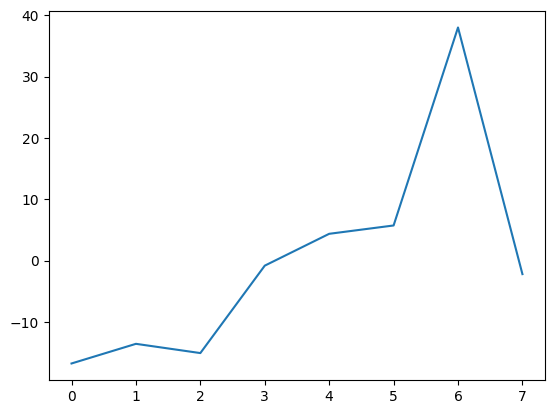

In [39]:
deviation.append(get_deviation_for_subjects(17, "PLAYER_CRASH_WALL", range(10,11), window=2))

plt.plot([i for i in range(8)], deviation[len(deviation)-1])
#plt.yticks([-1+i/10 for i in range(21)])
plt.show()

Reading 0 ... 954499  =      0.000 ...  1908.998 secs...
211


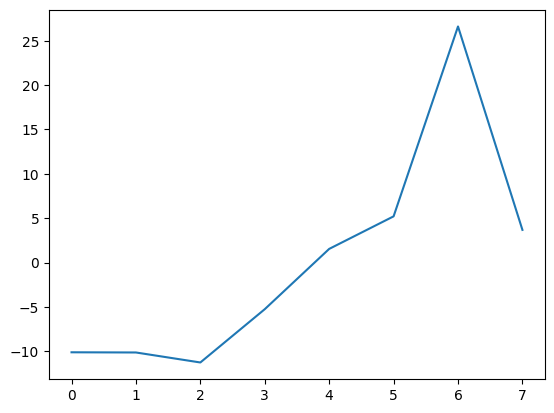

In [40]:
deviation.append(get_deviation_for_subjects(17, "PLAYER_CRASH_WALL", range(10,11), window=6))

plt.plot([i for i in range(8)], deviation[len(deviation)-1])
#plt.yticks([-1+i/10 for i in range(21)])
plt.show()

Reading 0 ... 954499  =      0.000 ...  1908.998 secs...
211


/var/folders/zj/7fxv5dh53xs9bw4_55222q6c0000gn/T/ipykernel_43206/9202195.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(not_aggregated))  # You can change 'tab10' to other colormaps


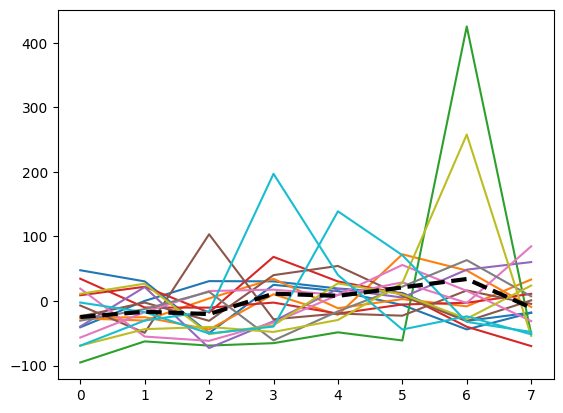

In [81]:
aggregaed, not_aggregated = get_deviation_for_subjects(17, "PLAYER_CRASH_WALL", range(10,11))
plot_seperated(aggregaed, not_aggregated)

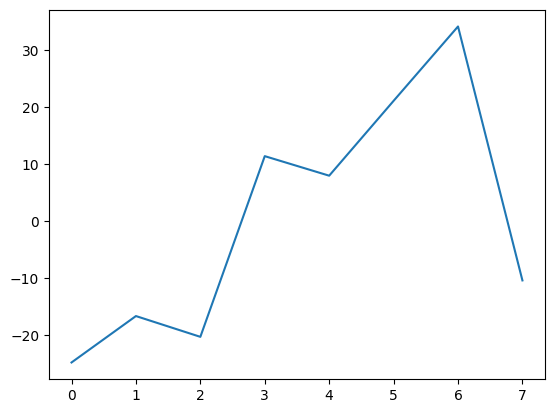

In [82]:
plot_123(aggregaed)

Reading 0 ... 954499  =      0.000 ...  1908.998 secs...
103


/var/folders/zj/7fxv5dh53xs9bw4_55222q6c0000gn/T/ipykernel_43206/9202195.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(not_aggregated))  # You can change 'tab10' to other colormaps


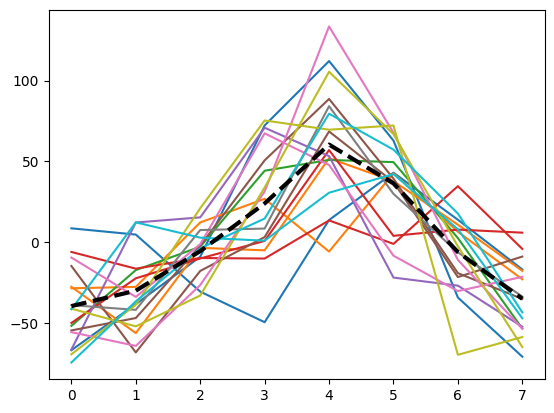

In [65]:
aggregaed, not_aggregated = get_deviation_for_subjects(17, "PLAYER_CRASH_ENEMY", range(4,5))
plot_seperated(aggregaed, not_aggregated)